<a href="https://colab.research.google.com/github/mkrvtsv/Neural_Networks_and_CV/blob/master/%5Bhomework%5DBERT_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework

Привет! В этой домашнем задании ты научишься обучении модели BERT. На семинаре был разобран код модели, здесь же посмотрим на то, как надо обработать данные, чтобы на них модель могла учиться. 

Замечания по выполнению задания:

- Код внутри блока `<DON'T TOUCH THIS!>` используется для проверки задания, его нельзя трогать. 

- Внутри блока `<YOUR CODE>` может больше кода, чем там показано изначально.

- От задания требуется написания небольшого отчета в конце.


Для начала загрузи нужные библиотеки.

In [0]:
!pip install transformers catalyst


In [0]:
import os
import random
import sys
import urllib.request
import zipfile

import numpy as np
import pandas as pd
from tqdm import tqdm, trange

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, Dataset

import transformers

from catalyst.dl import SupervisedRunner
from catalyst.dl.callbacks import AccuracyCallback, SchedulerCallback, F1ScoreCallback
from catalyst.utils import set_global_seed, prepare_cudnn


/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



Внизу идет технический код, который нужен для загрузки датасетов. Его можно уменьшить, выбрав только некоторые из них. Для того, что бы зачесть задание, надо выбрать не менее двух задач, для хотя бы одной из которых нужно использовать два предложения(ответ и вопрос, два предложения и прочее). Подробнее про датасеты [здесь](https://gluebenchmark.com/).

In [0]:
TASKS = ["CoLA", "SST", "MRPC", "QQP", "STS", "MNLI", "SNLI", "QNLI", "RTE", "WNLI"]
TASK2PATH = {
    "CoLA": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FCoLA.zip?alt=media&token=46d5e637-3411-4188-bc44-5809b5bfb5f4",
    "SST": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSST-2.zip?alt=media&token=aabc5f6b-e466-44a2-b9b4-cf6337f84ac8",
    "MRPC": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2Fmrpc_dev_ids.tsv?alt=media&token=ec5c0836-31d5-48f4-b431-7480817f1adc",
    "QQP": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FQQP.zip?alt=media&token=700c6acf-160d-4d89-81d1-de4191d02cb5",
    "STS": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSTS-B.zip?alt=media&token=bddb94a7-8706-4e0d-a694-1109e12273b5",
    "MNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FMNLI.zip?alt=media&token=50329ea1-e339-40e2-809c-10c40afff3ce",
    "SNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSNLI.zip?alt=media&token=4afcfbb2-ff0c-4b2d-a09a-dbf07926f4df",
    "QNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FQNLIv2.zip?alt=media&token=6fdcf570-0fc5-4631-8456-9505272d1601",
    "RTE": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FRTE.zip?alt=media&token=5efa7e85-a0bb-4f19-8ea2-9e1840f077fb",
    "WNLI": "https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FWNLI.zip?alt=media&token=068ad0a0-ded7-4bd7-99a5-5e00222e0faf",
}

MRPC_TRAIN = "https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_train.txt"
MRPC_TEST = "https://dl.fbaipublicfiles.com/senteval/senteval_data/msr_paraphrase_test.txt"

data_dir = "data/"
max_seq_length = 128


In [0]:
def download_and_extract(task, data_dir):
    print("Downloading and extracting %s..." % task)
    data_file = "%s.zip" % task
    urllib.request.urlretrieve(TASK2PATH[task], data_file)
    with zipfile.ZipFile(data_file) as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(data_file)
    print("\tCompleted!")

def format_mrpc(data_dir, path_to_data):
    print("Processing MRPC...")
    mrpc_dir = os.path.join(data_dir, "MRPC")
    if not os.path.isdir(mrpc_dir):
        os.mkdir(mrpc_dir)
    if path_to_data:
        mrpc_train_file = os.path.join(path_to_data, "msr_paraphrase_train.txt")
        mrpc_test_file = os.path.join(path_to_data, "msr_paraphrase_test.txt")
    else:
        print("Local MRPC data not specified, downloading data from %s" % MRPC_TRAIN)
        mrpc_train_file = os.path.join(mrpc_dir, "msr_paraphrase_train.txt")
        mrpc_test_file = os.path.join(mrpc_dir, "msr_paraphrase_test.txt")
        urllib.request.urlretrieve(MRPC_TRAIN, mrpc_train_file)
        urllib.request.urlretrieve(MRPC_TEST, mrpc_test_file)
    assert os.path.isfile(mrpc_train_file), "Train data not found at %s" % mrpc_train_file
    assert os.path.isfile(mrpc_test_file), "Test data not found at %s" % mrpc_test_file
    urllib.request.urlretrieve(TASK2PATH["MRPC"], os.path.join(mrpc_dir, "dev_ids.tsv"))

    dev_ids = []
    with open(os.path.join(mrpc_dir, "dev_ids.tsv"), encoding="utf8") as ids_fh:
        for row in ids_fh:
            dev_ids.append(row.strip().split("\t"))

    with open(mrpc_train_file, encoding="utf8") as data_fh, open(
        os.path.join(mrpc_dir, "train.tsv"), "w", encoding="utf8"
    ) as train_fh, open(os.path.join(mrpc_dir, "dev.tsv"), "w", encoding="utf8") as dev_fh:
        header = data_fh.readline()
        train_fh.write(header)
        dev_fh.write(header)
        for row in data_fh:
            label, id1, id2, s1, s2 = row.strip().split("\t")
            if [id1, id2] in dev_ids:
                dev_fh.write("%s\t%s\t%s\t%s\t%s\n" % (label, id1, id2, s1, s2))
            else:
                train_fh.write("%s\t%s\t%s\t%s\t%s\n" % (label, id1, id2, s1, s2))

    with open(mrpc_test_file, encoding="utf8") as data_fh, open(
        os.path.join(mrpc_dir, "test.tsv"), "w", encoding="utf8"
    ) as test_fh:
        header = data_fh.readline()
        test_fh.write("index\t#1 ID\t#2 ID\t#1 String\t#2 String\n")
        for idx, row in enumerate(data_fh):
            label, id1, id2, s1, s2 = row.strip().split("\t")
            test_fh.write("%d\t%s\t%s\t%s\t%s\n" % (idx, id1, id2, s1, s2))
    print("\tCompleted!")
    

In [0]:
TASKS = ['RTE', 'SST'] # Или можно просто сюда вписать те датасеты, которые ты выбрал.

for task in TASKS:
    if task == "MRPC":
        format_mrpc(data_dir, None)
    else:
        download_and_extract(task, data_dir)
        

	Completed!
	Completed!


In [0]:
!ls ./data/RTE


dev.tsv  test.tsv  train.tsv


Загрузи один из выбранных датасет с помощью Pandas(не обязательно через него, но так проще) и посмотри на него.

In [0]:
!ls ./data/SST-2


dev.tsv  original  test.tsv  train.tsv


In [0]:
!ls ./data/SST-2/original


datasetSentences.txt  dictionary.txt		README.txt	      SOStr.txt
datasetSplit.txt      original_rt_snippets.txt	sentiment_labels.txt  STree.txt


In [0]:
# Вместо test-а возьмите valid, а valid сделай из train.
'''
Для RTE есть нормальный valid и test соответственно dev.tsv и test.tsv,
поэтому пока использую их и train не разбиваю, что сделать не сложно.
'''

# <YOUR CODE>
train_pd = pd.read_csv('./data/RTE/train.tsv', sep='\t', index_col='index')
test_pd = pd.read_csv('./data/RTE/dev.tsv', sep='\t', index_col='index')

mask = np.random.rand(len(train_pd)) < 0.9
valid_pd = train_pd[~mask]
train_pd = train_pd[mask]
print(f'train: {train_pd.shape}, valid: {valid_pd.shape}, test: {test_pd.shape}')
# </YOUR CODE>


train: (2218, 3), valid: (272, 3), test: (277, 3)


In [0]:
train_pd.head()


,sentence1,sentence2,label
index,,,
0,No Weapons of Mass Destruction Found in Iraq Yet.,Weapons of Mass Destruction Found in Iraq.,not_entailment
1,"A place of sorrow, after Pope John Paul II die...",Pope Benedict XVI is the new leader of the Rom...,entailment
2,Herceptin was already approved to treat the si...,Herceptin can be used to treat breast cancer.,entailment
3,"Judie Vivian, chief executive at ProMedica, a ...",The previous name of Ho Chi Minh City was Saigon.,entailment
4,A man is due in court later charged with the m...,Paul Stewart Hutchinson is accused of having s...,not_entailment


In [0]:
train_pd.iloc[0, 0], train_pd.iloc[0, 1]


('No Weapons of Mass Destruction Found in Iraq Yet.',
 'Weapons of Mass Destruction Found in Iraq.')

In [0]:
train_pd.label.value_counts()


entailment        1123
not_entailment    1094
Name: label, dtype: int64

Для начала рассмотрим важную часть обработки текста для трансфомера (и не только) – токенайзер.

В качестве примера токенайзера воспользуемся внутренним из библиотеки transformers, обученным для BERT-а. Посмотрим, что он умеет.

In [0]:
model_name = 'bert-base-uncased'

tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)


Посмотрим, как происходит токенизация предложения.

In [0]:
test_sentence = "Hide new secretions from the parental units."
print(tokenizer.tokenize(test_sentence))


['hide', 'new', 'secret', '##ions', 'from', 'the', 'parental', 'units', '.']


Видно, что предложения разделяются не на слова, а подслова. Токены, которые надо объеденить в слова для получения "нормального" текста, выделены с помощью `##`. Посмотрим, как различаются коды токенов с этим символом и без него.

In [0]:
print(tokenizer.convert_tokens_to_ids(['ions']))
print(tokenizer.convert_tokens_to_ids(['##ions']))


[15956]
[8496]


Для токенизации предложений воспользуемся методом `encode`. Он принимает предложение как строку или список токенов**(!)**.

In [0]:
print(tokenizer.encode(test_sentence))


[101, 5342, 2047, 3595, 8496, 2013, 1996, 18643, 3197, 1012, 102]


Добавились специальные токены впереди и сзади предложения. Посмотрим на весь список специальных токенов:

In [0]:
print(tokenizer.special_tokens_map)
print({i: j for i, j in zip(tokenizer.all_special_tokens, tokenizer.all_special_ids)})


{'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}
{'[SEP]': 102, '[CLS]': 101, '[MASK]': 103, '[UNK]': 100, '[PAD]': 0}


Посмотрим, что ещё может делать токенайзер. Что требуется нам для обучения BERT-а: добавить паддинг, получить маску аттеншена и тип токенов. Попробуем сделать это самостоятельно и посмотрим, как это сделать с помощью токенайзера.

Выбери два предложения из обучающей выборки. Получи их токены с помощью метода `tokenize`. Объедени списки токенов так, чтобы модель могла различать, что они от разных предложений. 

(Подсказка: на семинаре была картинка с эмбеддингами. Она может подсказать, что надо изменить в токенах предложения) 

In [0]:
# <YOUR CODE>
s1, s2 = train_pd.loc[383, 'sentence1'], train_pd.loc[383, 'sentence2']
tokenized_s1, tokenized_s2 = tokenizer.tokenize(s1), tokenizer.tokenize(s2)
s_union = tokenized_s1 + ['[SEP]'] + tokenized_s2
# </YOUR CODE>

# <DON'T TOUCH THIS!>
assert tokenizer.encode(s_union) == tokenizer.encode(s1, s2), "Not equal"
# </DON'T TOUCH THIS!>


Теперь надо добавь нулей в полученный список чисел, чтобы они легко складывались в батчи.

In [0]:
# <YOUR CODE>
encoded_full = tokenizer.encode(s_union)
encoded_full = encoded_full + [0] * (max_seq_length - len(encoded_full))

print(encoded_full[-20:])
# </YOUR CODE>

# <DON'T TOUCH THIS!>
encoded_correct = tokenizer.encode(s1, s2, max_length=max_seq_length, pad_to_max_length=True)
assert len(encoded_full) == len(encoded_correct), "Different length"
assert encoded_full == encoded_correct, "Not equal"
# </DON'T TOUCH THIS!>


[6017, 2386, 1012, 102, 25616, 4880, 7174, 2003, 1996, 2873, 1997, 1996, 2394, 2136, 1012, 102, 0, 0, 0, 0]


В модель также надо кинуть маску для механизма внимания и тип предложения для каждого токена. Сделай их.

In [0]:
# <YOUR CODE>
token_type_ids = [0 for e in encoded_full[: encoded_full.index(102)+1]] +\
                 [e > 0 for e in encoded_full[encoded_full.index(102)+1 :]]
attention_mask = [e > 0 for e in encoded_full]

print(list(map(int, token_type_ids[-20:])))
print(list(map(int, attention_mask[-20:])))
# </YOUR CODE>

# <DON'T TOUCH THIS!>
encoded_plus = tokenizer.encode_plus(s1, text_pair=s2, max_length=max_seq_length, pad_to_max_length=True)
assert len(token_type_ids) == len(encoded_plus['token_type_ids']), "Different length in token_type_ids"
assert token_type_ids == encoded_plus['token_type_ids'], "Not equal token_type_ids"
assert len(attention_mask) == len(encoded_plus['attention_mask']), "Different length in attention_mask"
assert attention_mask == encoded_plus['attention_mask'], "Not equal attention_mask"
# </DON'T TOUCH THIS!>


[0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]


Как видно из тестов, все нужные для обработки текста для BERT-а вещи может делать токенизатор из `transformers`. Но не все токенизаторы настолько функциональны. Их (почти)полный список:
- [Sentence Piece](https://github.com/google/sentencepiece/)
- [fastBPE](https://github.com/glample/fastBPE)
- [Hugging Face Tokenizers](https://github.com/huggingface/tokenizers)
- [YouTokenToMe](https://github.com/VKCOM/YouTokenToMe)

Их сравнивают [здесь](https://github.com/VKCOM/YouTokenToMe/blob/master/benchmark.md) или [здесь](https://towardsdatascience.com/a-small-timing-experiment-on-the-new-tokenizers-library-a-write-up-7caab6f80ea6). Также специальные токенайзеры, которые специализируются на "незападные" языки. Но не будем на них останавливаться.

Теперь ты знаешь достаточно, чтобы написать обработчик данных. Что надо сделать: получить из данных предложения, закодировать их, получить аттенш маску и тип токенов, не забыть про таргет. 

P.S. Есть более быстрая версия токенизатора для BERT внутри `transformers`, `BertTokenizerFast`. 

P.S.S. Теперь надо использовать только функционал токенайзера для кодирования предложений, без велосипедов.

In [0]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

        # <YOUR CODE>
        self.features = self.data.apply(lambda row:
                                        tokenizer.
                                        encode(row['sentence1'],
                                               row['sentence2'],
                                               max_length=max_seq_length,
                                               pad_to_max_length=True), axis=1).values

        self.attention_mask = self.data.apply(lambda row:
                                              tokenizer.
                                              encode_plus(row['sentence1'],
                                                          text_pair=row['sentence2'],
                                                          max_length=max_seq_length,
                                                          pad_to_max_length=True)['attention_mask'], axis=1).values

        self.token_types_ids = self.data.apply(lambda row:
                                               tokenizer.
                                               encode_plus(row['sentence1'],
                                                           text_pair=row['sentence2'],
                                                           max_length=max_seq_length,
                                                           pad_to_max_length=True)['token_type_ids'], axis=1).values

        self.target = self.data.label.apply(lambda e: 0 if e == 'entailment' else 1).values
        # </YOUR CODE>

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.features[idx]),
            'attention_mask': torch.tensor(self.attention_mask[idx]),
            'token_type_ids': torch.tensor(self.token_types_ids[idx]),
            'targets': torch.tensor(self.target[idx])
        }


Воспользуйтесь семинаром и построй модель для классификации предложений.

(Подсказка: весь код BERT-а из семинара доступен из библиотеки `transformers`)

In [0]:
class BertForSequenceClassification(nn.Module):
    def __init__(self, pretrained_model_name: str, num_labels: int):
        super().__init__()

        # <YOUR CODE>
        config = transformers.BertConfig.from_pretrained(
            pretrained_model_name, 
            num_labels=num_labels
        )

        self.bert = transformers.BertModel.from_pretrained(
            pretrained_model_name,
            config=config
        )

        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        # </YOUR CODE>

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):

        # <YOUR CODE>
        assert attention_mask is not None, "attention mask is none"
        bert_output = self.bert(input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids)

        hidden_state = bert_output[0]
        pooled_output = hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        # </YOUR CODE>

        return logits


Выбери из [списка](https://huggingface.co/models?search=google%2Fbert_) несколько моделей, которые ты будешь обучать. Сравни их качество на выбранных датасетах. 

Лучше всего будет выбрать одну основную конфигурацию, и другие с небольшим изменением. Например, пройтись по такой сетке: `{'layers': [2, 4], 'num_heads': [2, 4]}`. 

In [0]:


num_labels = 2      # 2



In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# <YOUR CODE>
pretrained_model_name = 'google/bert_uncased_L-4_H-256_A-4' # "bert-base-uncased"
# 'google/bert_uncased_L-2_H-128_A-2', 'google/bert_uncased_L-2_H-256_A-4',
# 'google/bert_uncased_L-4_H-128_A-2', 'google/bert_uncased_L-4_H-256_A-4
tokenizer = transformers.AutoTokenizer.from_pretrained(pretrained_model_name)
model = BertForSequenceClassification(pretrained_model_name, num_labels=num_labels)
# </YOUR CODE>

model.to(device)
print("Success!")



Success!


In [0]:
batch_size = 32


# <YOUR CODE>
train_dataset = TextClassificationDataset(train_pd, tokenizer)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

valid_dataset = TextClassificationDataset(valid_pd, tokenizer)
valid_sampler = RandomSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=batch_size)

test_dataset = TextClassificationDataset(test_pd, tokenizer)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

dataloaders = {
    "train": train_dataloader,
    "valid": valid_dataloader,
    "test": test_dataloader
}

print(f"Dataset size: {len(dataloaders)}")
# </YOUR CODE>


Dataset size: 3


In [0]:
seed = 404
set_global_seed(seed)
prepare_cudnn(True)


In [0]:
# Гиперпараметры для обучения модели. Подбери нужные для каждой модели.

epochs = 10
lr = 1e-5 
warmup_steps = len(train_dataloader) // 2 

t_total = len(train_dataloader) * epochs


Добавь Loss, Optimizer и Scheduler.

In [0]:
optimizer_grouped_parameters = [
    {"params": [p for n, p in model.named_parameters()], "weight_decay": 0.0},
]

# <YOUR CODE>
criterion = torch.nn.CrossEntropyLoss()
optimizer = transformers.AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total
)
# </YOUR CODE>


In [0]:
log_dir = 'logs/'


Для обучения модели воспользуемся библиотекой `catalyst`.

In [0]:
runner = SupervisedRunner(
    input_key=(
        "input_ids",
        "attention_mask",
        "token_type_ids"
    ),
    input_target_key='targets'
)

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=dataloaders,
    callbacks=[
        AccuracyCallback(num_classes=num_labels),
        SchedulerCallback(mode='batch'),
    ],
    logdir=log_dir,
    num_epochs=epochs,
    verbose=True,
)


1/10 * Epoch (train):   3% 2/70 [00:00<00:09,  7.45it/s, accuracy01=0.469, loss=0.934, lr=5.714e-07, momentum=0.900]

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



1/10 * Epoch (train): 100% 70/70 [00:07<00:00,  9.98it/s, accuracy01=0.300, loss=0.872, lr=9.474e-06, momentum=0.900]
1/10 * Epoch (valid): 100% 9/9 [00:00<00:00, 31.68it/s, accuracy01=0.625, loss=0.684]
1/10 * Epoch (test): 100% 9/9 [00:00<00:00, 30.31it/s, accuracy01=0.714, loss=0.579]
[2020-05-11 14:14:53,020] 
1/10 * Epoch 1 (_base): lr=9.474e-06 | momentum=0.9000
1/10 * Epoch 1 (train): accuracy01=0.5373 | loss=0.7442 | lr=7.436e-06 | momentum=0.9000
1/10 * Epoch 1 (valid): accuracy01=0.5833 | loss=0.6784
1/10 * Epoch 1 (test): accuracy01=0.5794 | loss=0.6632


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning:

Please also save or load the state of the optimzer when saving or loading the scheduler.



2/10 * Epoch (train): 100% 70/70 [00:06<00:00, 10.04it/s, accuracy01=0.500, loss=0.707, lr=8.421e-06, momentum=0.900]
2/10 * Epoch (valid): 100% 9/9 [00:00<00:00, 31.45it/s, accuracy01=0.562, loss=0.699]
2/10 * Epoch (test): 100% 9/9 [00:00<00:00, 30.60it/s, accuracy01=0.810, loss=0.565]
[2020-05-11 14:15:01,944] 
2/10 * Epoch 2 (_base): lr=8.421e-06 | momentum=0.9000
2/10 * Epoch 2 (train): accuracy01=0.5737 | loss=0.6781 | lr=8.940e-06 | momentum=0.9000
2/10 * Epoch 2 (valid): accuracy01=0.5764 | loss=0.6733
2/10 * Epoch 2 (test): accuracy01=0.5969 | loss=0.6543
3/10 * Epoch (train): 100% 70/70 [00:07<00:00,  9.74it/s, accuracy01=0.500, loss=0.687, lr=7.368e-06, momentum=0.900]
3/10 * Epoch (valid): 100% 9/9 [00:00<00:00, 31.30it/s, accuracy01=0.562, loss=0.650]
3/10 * Epoch (test): 100% 9/9 [00:00<00:00, 31.02it/s, accuracy01=0.762, loss=0.539]
[2020-05-11 14:15:11,347] 
3/10 * Epoch 3 (_base): lr=7.368e-06 | momentum=0.9000
3/10 * Epoch 3 (train): accuracy01=0.5987 | loss=0.6605 | 

In [0]:
# Вместо test-а возьмите valid, а valid сделай из train.

# <YOUR CODE>
train_pd = pd.read_csv('./data/SST-2/train.tsv', sep='\t')
test_pd = pd.read_csv('./data/SST-2/dev.tsv', sep='\t')

mask = np.random.rand(len(train_pd)) < 0.7
valid_pd = train_pd[~mask]
train_pd = train_pd[mask]
print(f'train: {train_pd.shape}, valid: {valid_pd.shape}, test: {test_pd.shape}')
# </YOUR CODE>


train: (47119, 2), valid: (20230, 2), test: (872, 2)


In [0]:
train_pd.head()


,sentence,label
0,hide new secretions from the parental units,0
1,"contains no wit , only labored gags",0
2,that loves its characters and communicates som...,1
3,remains utterly satisfied to remain the same t...,0
4,on the worst revenge-of-the-nerds clichés the ...,0


In [0]:
train_pd.label.value_counts()


1    26118
0    21001
Name: label, dtype: int64

In [0]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

        # <YOUR CODE>
        self.features = self.data.apply(lambda row:
                                        tokenizer.
                                        encode(row['sentence'],
                                               max_length=max_seq_length,
                                               pad_to_max_length=True), axis=1).values

        self.attention_mask = self.data.apply(lambda row:
                                              tokenizer.
                                              encode_plus(row['sentence'],
                                                          max_length=max_seq_length,
                                                          pad_to_max_length=True)['attention_mask'], axis=1).values

        self.token_types_ids = self.data.apply(lambda row:
                                               tokenizer.
                                               encode_plus(row['sentence'],
                                                           max_length=max_seq_length,
                                                           pad_to_max_length=True)['token_type_ids'], axis=1).values

        self.target = self.data.label.values
        # </YOUR CODE>

    def __len__(self):
        return len(self.features) 

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.features[idx]), 
            'attention_mask': torch.tensor(self.attention_mask[idx]),
            'token_type_ids': torch.tensor(self.token_types_ids[idx]),
            'targets': torch.tensor(self.target[idx])
        }
        

In [0]:


num_labels = 2



In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# <YOUR CODE>
pretrained_model_name = 'google/bert_uncased_L-4_H-256_A-4'
# 'google/bert_uncased_L-2_H-128_A-2', 'google/bert_uncased_L-2_H-256_A-4',
# 'google/bert_uncased_L-4_H-128_A-2', 'google/bert_uncased_L-4_H-256_A-4
tokenizer = transformers.AutoTokenizer.from_pretrained(pretrained_model_name)
model = BertForSequenceClassification(pretrained_model_name, num_labels=num_labels)
# </YOUR CODE>

model.to(device)
print("Success!")


Success!


In [0]:
batch_size = 32


# <YOUR CODE>
train_dataset = TextClassificationDataset(train_pd, tokenizer)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

valid_dataset = TextClassificationDataset(valid_pd, tokenizer)
valid_sampler = RandomSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=batch_size)

test_dataset = TextClassificationDataset(test_pd, tokenizer)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=batch_size)

dataloaders = {
    "train": train_dataloader,
    "valid": valid_dataloader,
    "test": test_dataloader
}

print(f"Dataset size: {len(dataloaders)}")
# </YOUR CODE>


Dataset size: 3


In [0]:
seed = 404
set_global_seed(seed)
prepare_cudnn(True)


In [0]:
# Гиперпараметры для обучения модели. Подбери нужные для каждой модели.

epochs = 10
lr = 1e-5
warmup_steps = len(train_dataloader) // 2

t_total = len(train_dataloader) * epochs


Добавь Loss, Optimizer и Scheduler.

In [0]:
optimizer_grouped_parameters = [
    {"params": [p for n, p in model.named_parameters()], "weight_decay": 0.0},     #  "weight_decay": 0.0
]

# <YOUR CODE>
criterion = torch.nn.CrossEntropyLoss()
optimizer = transformers.AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total
)
# </YOUR CODE>


In [0]:
log_dir = 'logs/'


Для обучения модели воспользуемся библиотекой `catalyst`.

In [0]:
runner = SupervisedRunner(
    input_key=(
        "input_ids",
        "attention_mask",
        "token_type_ids"
    ),
    input_target_key='targets'
)

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=dataloaders,
    callbacks=[
        AccuracyCallback(num_classes=num_labels),
        SchedulerCallback(mode='batch'),
    ],
    logdir=log_dir,
    num_epochs=epochs,
    verbose=True,
)


1/10 * Epoch (train):   0% 2/1473 [00:00<03:16,  7.49it/s, accuracy01=0.469, loss=0.817, lr=2.717e-08, momentum=0.900]

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.



1/10 * Epoch (train): 100% 1473/1473 [02:25<00:00, 10.13it/s, accuracy01=0.867, loss=0.281, lr=9.473e-06, momentum=0.900]
1/10 * Epoch (valid): 100% 633/633 [00:20<00:00, 30.21it/s, accuracy01=1.000, loss=0.370]
1/10 * Epoch (test): 100% 28/28 [00:00<00:00, 30.80it/s, accuracy01=0.750, loss=0.456]
[2020-05-11 15:52:33,851] 
1/10 * Epoch 1 (_base): lr=9.473e-06 | momentum=0.9000
1/10 * Epoch 1 (train): accuracy01=0.7064 | loss=0.5408 | lr=7.373e-06 | momentum=0.9000
1/10 * Epoch 1 (valid): accuracy01=0.8380 | loss=0.3687
1/10 * Epoch 1 (test): accuracy01=0.7913 | loss=0.4283


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning:

Please also save or load the state of the optimzer when saving or loading the scheduler.



2/10 * Epoch (train): 100% 1473/1473 [02:26<00:00, 10.08it/s, accuracy01=0.867, loss=0.240, lr=8.421e-06, momentum=0.900]
2/10 * Epoch (valid): 100% 633/633 [00:21<00:00, 30.01it/s, accuracy01=0.833, loss=0.242]
2/10 * Epoch (test): 100% 28/28 [00:00<00:00, 30.31it/s, accuracy01=0.875, loss=0.327]
[2020-05-11 15:55:23,554] 
2/10 * Epoch 2 (_base): lr=8.421e-06 | momentum=0.9000
2/10 * Epoch 2 (train): accuracy01=0.8434 | loss=0.3586 | lr=8.947e-06 | momentum=0.9000
2/10 * Epoch 2 (valid): accuracy01=0.8705 | loss=0.3072
2/10 * Epoch 2 (test): accuracy01=0.8304 | loss=0.4082
3/10 * Epoch (train): 100% 1473/1473 [02:25<00:00, 10.11it/s, accuracy01=0.800, loss=0.256, lr=7.368e-06, momentum=0.900]
3/10 * Epoch (valid): 100% 633/633 [00:20<00:00, 30.29it/s, accuracy01=0.667, loss=0.354]
3/10 * Epoch (test): 100% 28/28 [00:00<00:00, 31.20it/s, accuracy01=0.875, loss=0.241]
[2020-05-11 15:58:12,536] 
3/10 * Epoch 3 (_base): lr=7.368e-06 | momentum=0.9000
3/10 * Epoch 3 (train): accuracy01=0.8

# New Section

In [0]:
!ls ./logs/


_base_log  checkpoints	log.txt  test_log  train_log  valid_log


In [0]:
!cat ./logs/log.txt


[2020-05-11 12:00:06,289] 
1/10 * Epoch 1 (_base): lr=4.737e-05 | momentum=0.9000
1/10 * Epoch 1 (train): accuracy01=0.5708 | loss=0.6787 | lr=3.718e-05 | momentum=0.9000
1/10 * Epoch 1 (valid): accuracy01=0.6224 | loss=0.6584
1/10 * Epoch 1 (test): accuracy01=0.6280 | loss=0.6481
[2020-05-11 12:03:20,993] 
2/10 * Epoch 2 (_base): lr=4.211e-05 | momentum=0.9000
2/10 * Epoch 2 (train): accuracy01=0.7552 | loss=0.5039 | lr=4.470e-05 | momentum=0.9000
2/10 * Epoch 2 (valid): accuracy01=0.6644 | loss=0.7001
2/10 * Epoch 2 (test): accuracy01=0.6645 | loss=0.6821
[2020-05-11 12:05:52,795] 
3/10 * Epoch 3 (_base): lr=3.684e-05 | momentum=0.9000
3/10 * Epoch 3 (train): accuracy01=0.9268 | loss=0.2043 | lr=3.944e-05 | momentum=0.9000
3/10 * Epoch 3 (valid): accuracy01=0.6732 | loss=0.9063
3/10 * Epoch 3 (test): accuracy01=0.6452 | loss=0.9957
[2020-05-11 12:08:27,397] 
4/10 * Epoch 4 (_base): lr=3.158e-05 | momentum=0.9000
4/10 * Epoch 4 (train): accuracy01=0.9835 | loss=0.0556 | lr=3.417e-05 |

Ииии отчет!

Напиши внизу небольшой отчет о проделанной работе. Ожидается сравнение результатов модели с разным количеством голов/слоев на разных датасетах на `test`. Если для оценки качества на датасете используется необычная метрика(не Accuracy или F1), то можно использовать один из них. Было бы круто, если бы вычислялась нужная метрика и она использовалась в отчете.

<ТВОЙ ОТЧЕТ>

Очевидно (датафрейм с результатами - в самой нижней ячейке), что на качество обучения влияет и количество слоёв, и количество голов. При этом, рост количества голов улучшает результаты сильней, чем рост количества слоёв.

Сами по себе результаты получились примерно те же, что и на huggingface.co
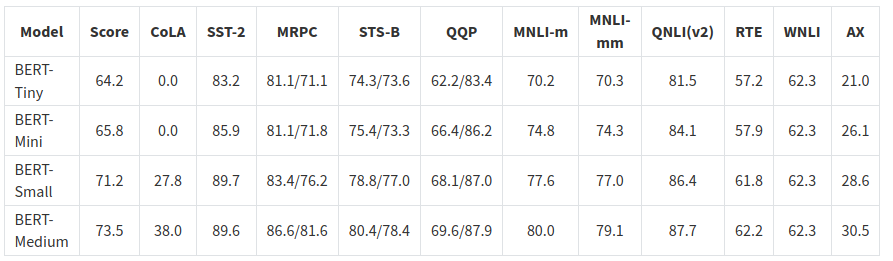

Я слегка затянул с выполнением этого задания, потому не попробовал другие задачи, модели и параметры. Например, похоже, что 10 - многовато для обучения. Но в учебных целях, мне кажется, выполненного достаточно.

</ТВОЙ ОТЧЕТ>

In [0]:
data = {'google/bert_uncased': ['L-2_H-128_A-2', 'L-2_H-256_A-4', 'L-4_H-128_A-2', 'L-4_H-256_A-4'],
        'RTE_loss': [0.6879, 0.6971, 0.6817, 0.6256],
        'RTE_accuracy': [0.5531, 0.5392, 0.5514, 0.6420],
        'SST-2_loss': [0.4447, 0.4066, 0.4387, 0.4052,],
        'SST-2_accuracy': [0.8025, 0.8460, 0.8248, 0.8493],
        }
        

In [3]:
pd.DataFrame(data).set_index('google/bert_uncased')


,RTE_loss,RTE_accuracy,SST-2_loss,SST-2_accuracy
google/bert_uncased,,,,
L-2_H-128_A-2,0.6879,0.5531,0.4447,0.8025
L-2_H-256_A-4,0.6971,0.5392,0.4066,0.8460
L-4_H-128_A-2,0.6817,0.5514,0.4387,0.8248
L-4_H-256_A-4,0.6256,0.6420,0.4052,0.8493
